# W01 · Deep Learning Foundations

This week introduces the basic building blocks of deep learning with tensors, gradients, and a tiny neural network.

**Ahmed Métwalli**

## Objectives

- Understand tensors and automatic differentiation at a high level
- Learn mean squared error (MSE)
- Train a tiny dense model on Fashion-MNIST
- Log training to TensorBoard

In [1]:
# Basic setup and reproducibility
import tensorflow as tf, keras, random, numpy as np, base64
print("TF:", tf.__version__, "| Keras:", keras.__version__)
print("Devices:", tf.config.list_physical_devices())

SHOW_SOLUTIONS = False

SEED = 2025
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

def reveal_solution(encoded: str, placeholder="Solution hidden. Set SHOW_SOLUTIONS=True to reveal."):
    if SHOW_SOLUTIONS:
        return base64.b64decode(encoded.encode('utf-8')).decode('utf-8')
    return placeholder

TF: 2.15.0 | Keras: 3.7.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Very Short Concepts

Tensors package numeric data into structured collections—scalars, vectors, matrices, and higher-order arrays—that deep-learning models can manipulate efficiently, as introduced in Chapters 1-2 of Goodfellow, Bengio, and Courville (2016).

Automatic differentiation lets us trace how changes in each tensor ripple through a computation graph so we can update model weights with gradient-based optimization; Géron (2022) walks through this workflow using TensorFlow's GradientTape API.

Mean squared error (MSE) measures the average squared gap between predictions and targets, grounding our training objective in a smooth loss landscape whose gradients align with the linear-regression derivation you just reviewed (Goodfellow et al., 2016; Géron, 2022).

## Math: MSE and gradients

The mean squared error compares predictions with targets.

$$\text{MSE}(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^{N} (y_i - \hat{y}_i)^2$$

For $\hat{y}_i = w x_i + b$ the gradients become

$$\frac{\partial L}{\partial w} = -\frac{2}{N} \sum_{i} x_i\,(y_i - (w x_i + b))$$

$$\frac{\partial L}{\partial b} = -\frac{2}{N} \sum_{i} (y_i - (w x_i + b))$$

### From algebra to NumPy code

The closed-form line fit below translates the gradient formulas from the previous math cell into vectorized NumPy operations so you can see the symbols come alive in code. Following Géron (2022, Ch. 4), pay attention to how broadcasting and matrix products mirror the analytical solution for linear regression.

In [3]:
# Worked Example A: Closed-form line fit with NumPy
import numpy as np
import matplotlib.pyplot as plt

Estimated slope: 2.532, intercept: 0.962


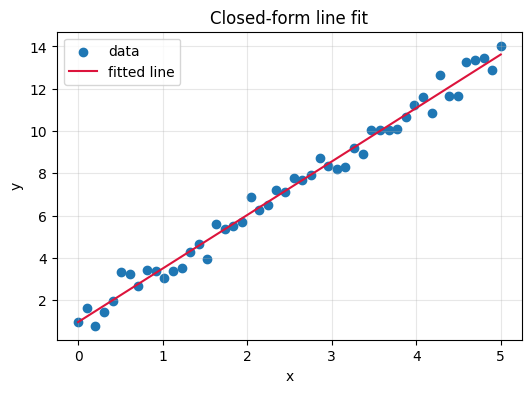

In [2]:
# Worked Example A: Closed-form line fit with NumPy
import numpy as np
import matplotlib.pyplot as plt

# Generate simple data with noise around a line
x = np.linspace(0.0, 5.0, 50) # 
noise = 0.5 * np.random.randn(50)
y = 2.5 * x + 1.0 + noise

# Estimate slope and intercept using covariance/variance intuition
x_mean = x.mean()
y_mean = y.mean()
cov_xy = np.mean((x - x_mean) * (y - y_mean))
var_x = np.mean((x - x_mean) ** 2)
slope = cov_xy / var_x
intercept = y_mean - slope * x_mean
print(f"Estimated slope: {slope:.3f}, intercept: {intercept:.3f}")

# Predictions from the fitted line
y_hat = slope * x + intercept

plt.figure(figsize=(6, 4))
plt.scatter(x, y, label="data")
plt.plot(x, y_hat, color="crimson", label="fitted line")
plt.title("Closed-form line fit")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

- The previous figure shows only the statistical approach of the line fitting.

### Stepping into automatic differentiation

To connect the NumPy solution with modern deep-learning practice, the next demo rebuilds the same regression task using `tf.GradientTape`. This mirrors the computational-graph perspective emphasized by Goodfellow et al. (2016) and shows how TensorFlow exposes gradients automatically once the forward pass is defined.

In [4]:
np.linspace(0.0, 5.0, 5)

array([0.  , 1.25, 2.5 , 3.75, 5.  ])

Estimated w,b: 2.9837114810943604 -0.7047974467277527


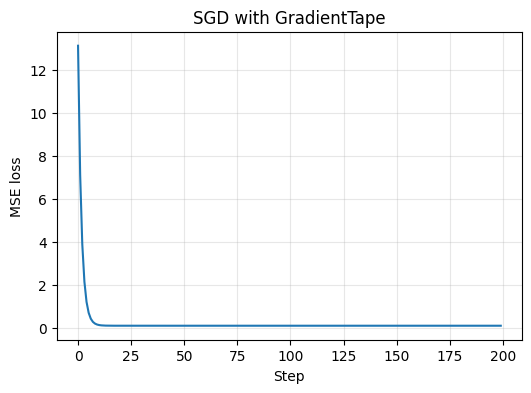

In [4]:
# Worked Example B: GradientTape mini-demo
import matplotlib.pyplot as plt
import tensorflow as tf, numpy as np

n = 256
x = tf.linspace(-2.0, 2.0, n)[:, None]
true_w, true_b = 3.0, -0.7
y = true_w * x + true_b + 0.3 * tf.random.normal(shape=x.shape, seed=SEED)

w = tf.Variable(tf.random.normal([1,1], stddev=0.1, seed=SEED))
b = tf.Variable(tf.zeros([1]))
opt = tf.keras.optimizers.SGD(learning_rate=0.1) # Optimizers

losses = []
for step in range(200):
    with tf.GradientTape() as tape: # 
        y_hat = x @ w + b # forward pass (SUM OF WEIGHTS)
        loss = tf.reduce_mean((y - y_hat) ** 2)
    grads = tape.gradient(loss, [w, b])
    opt.apply_gradients(zip(grads, [w, b]))
    losses.append(float(loss))

print("Estimated w,b:", float(w.numpy().squeeze()), float(b.numpy().squeeze()))

plt.figure(figsize=(6, 4))
plt.plot(losses)
plt.title("SGD with GradientTape")
plt.xlabel("Step")
plt.ylabel("MSE loss")
plt.grid(alpha=0.3)
plt.show()

## Lab plan

An MLP will be trained on Fashion-MNIST. Images will be flattened to 784 features. Early stopping and TensorBoard will be used.

In [18]:
info

tfds.core.DatasetInfo(
    name='fashion_mnist',
    full_name='fashion_mnist/3.0.1',
    description="""
    Fashion-MNIST is a dataset of Zalando's article images consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.
    """,
    homepage='https://github.com/zalandoresearch/fashion-mnist',
    data_dir='C:\\Users\\Metwalli\\tensorflow_datasets\\fashion_mnist\\3.0.1',
    file_format=tfrecord,
    download_size=29.45 MiB,
    dataset_size=36.42 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{DBLP:journals/corr/abs-1708-07747,


In [5]:
# Data loading with helper utilities
import tensorflow as tf
from dl_utils import load_tfds_dataset, prepare_for_training, build_callbacks, compile_and_fit, plot_history, visualize_model
from keras import layers, models

# Data
# Load Fashion-MNIST from TFDS so the lab can focus on modeling instead of boilerplate data wrangling.
(train_raw, info) = load_tfds_dataset("fashion_mnist", split="train", with_info=True)
test_raw = load_tfds_dataset("fashion_mnist", split="test")
num_classes = info.features["label"].num_classes


# Convert images to normalized flat vectors that     match the dense network input expectations.
def to_float_and_flatten(x, y):
    x = tf.image.convert_image_dtype(x, tf.float32)  # [0,1]
    x = tf.reshape(x, (-1,))                         # 28*28
    return x, y

# Batch and shuffle the training stream to approximate SGD with manageable memory footprints.
train_ds = prepare_for_training(train_raw.map(to_float_and_flatten), batch_size=64)
# Batch the evaluation stream without shuffling to keep epoch-level metrics stable.
test_ds  = prepare_for_training(test_raw.map(to_float_and_flatten),  batch_size=64, shuffle_buffer=None)

#### Given a dataset has input and output
- How to design?

Epoch 1/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.7409 - loss: 0.7471 - val_accuracy: 0.8429 - val_loss: 0.4380
Epoch 2/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8443 - loss: 0.4363 - val_accuracy: 0.8540 - val_loss: 0.4086
Epoch 3/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8589 - loss: 0.3960 - val_accuracy: 0.8654 - val_loss: 0.3787
Epoch 4/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8652 - loss: 0.3738 - val_accuracy: 0.8645 - val_loss: 0.3690
Epoch 5/5
938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8694 - loss: 0.3577 - val_accuracy: 0.8687 - val_loss: 0.3650
To inspect logs locally: tensorboard --logdir runs


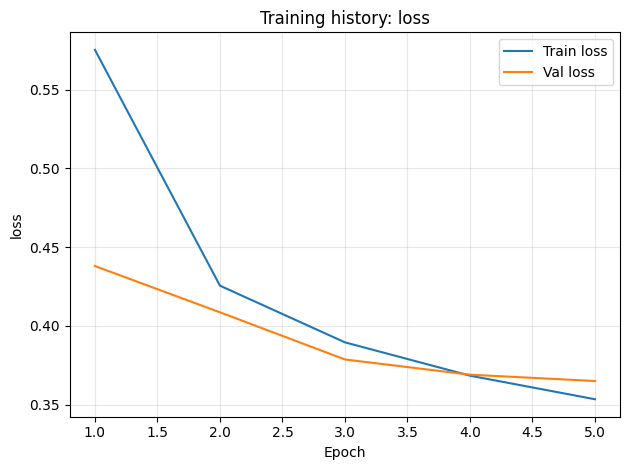

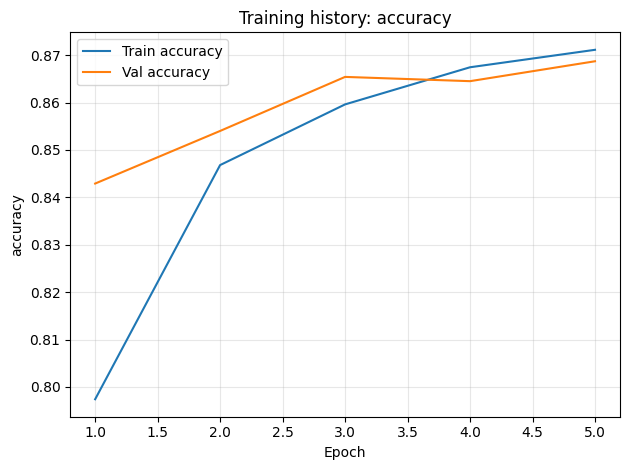

In [17]:
# Model definition, training, and visualization
# Stack a minimal dense network so we can isolate how architecture choices affect Fashion-MNIST accuracy.
model = models.Sequential([
    layers.Input((784,)), # 28*28*1
    layers.Dense(128, activation="relu"), # 128 > number of neurons of that layer
    layers.Dropout(0.3), # Later On (0 to 1)
    layers.Dense(num_classes, activation="softmax"), # Output layer
])

# Render the layer stack to reinforce the correspondence between code and the conceptual diagram.
visualize_model(model)

# Configure early stopping and TensorBoard callbacks to monitor learning dynamics in real time.
callbacks, logdir = build_callbacks(patience=3)
# Train the model while logging optimizer, loss, and metric history for later inspection.
history = compile_and_fit(
    model, train_ds,
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy", # type of loss for classification
    metrics=["accuracy"], # accuracy for the classification problem
    epochs=5, # Iteration over the whole dataset
    validation_ds=test_ds,
    callbacks=callbacks
)

# Summarize the TensorBoard logs inline so you can reason about training curves without leaving the notebook.
plot_history(history)
# Remind students where to find the saved run directory for deeper TensorBoard analysis.
print("To inspect logs locally: tensorboard --logdir runs")

## Concept checks

**Question 1.** What does "flattening" do here?

In [9]:
print(reveal_solution("SXQgcmVzaGFwZXMgZWFjaCAyOHgyOCBpbWFnZSBpbnRvIGEgdmVjdG9yIG9mIDc4NCBudW1iZXJzLg=="))

**Question 2.** Why does early stopping help?

In [10]:
print(reveal_solution("SXQgc3RvcHMgdHJhaW5pbmcgd2hlbiB2YWxpZGF0aW9uIGxvc3Mgc3RvcHMgaW1wcm92aW5nLCBhdm9pZGluZyB3YXN0ZWQgZXBvY2hzIGFuZCBvdmVyZml0dGluZy4="))

**Question 3.** What is the difference between training and validation accuracy?

In [11]:
print(reveal_solution("VHJhaW5pbmcgYWNjdXJhY3kgY29tZXMgZnJvbSB0aGUgYmF0Y2hlcyB0aGUgbW9kZWwgbGVhcm5zIG9uLCB3aGlsZSB2YWxpZGF0aW9uIGFjY3VyYWN5IHVzZXMgaGVsZC1vdXQgZGF0YS4="))

## Homework

- **Part A (Derivation):** Re-derive the gradient of MSE for $w$ and $b$ in one paragraph.
- **Part B (Code):** Change the hidden size (e.g., 64 or 256) and report the effect on accuracy using the training history plot.
- **Part C (Optimizer Study):** Compare Adam with SGD by rerunning `compile_and_fit` and summarize how the TensorBoard scalar curves differ after five epochs.
- **Part D (Reflection):** Connect one observation from the GradientTape demo or training logs to the gradient principles discussed above, citing the relevant section in Goodfellow et al. (2016) or Géron (2022).

## Further reading

- Ian Goodfellow, Yoshua Bengio, and Aaron Courville. *Deep Learning*. MIT Press, 2016.
- Aurélien Géron. *Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow*. O'Reilly Media, 3rd ed., 2022.

## Glossary of Lab 1 terms

- **Tensor:** Structured numeric container (scalar, vector, matrix, or higher-order array) that deep learning models manipulate efficiently.
- **Automatic differentiation:** Technique that tracks operations so gradients with respect to tensors can be computed automatically, enabling gradient-based learning.
- **Mean Squared Error (MSE):** Loss measuring the average squared difference between predictions and targets, providing smooth gradients for optimization.
- **Gradient:** Vector of partial derivatives of the loss with respect to model parameters, indicating how to adjust them during training.
- **`tf.GradientTape`:** TensorFlow context manager that records operations to compute gradients automatically after the forward pass.
- **Multilayer Perceptron (MLP):** Feedforward neural network composed of stacked dense layers; the lab’s primary model architecture.
- **Fashion-MNIST:** Dataset of 28×28 grayscale clothing images used as the lab’s classification task.
- **Flattening:** Reshaping each 2D image into a 1D vector so dense layers can process the data.
- **Early stopping:** Callback strategy that halts training when validation metrics stop improving, preventing overfitting and wasted epochs.
- **TensorBoard:** Visualization suite for monitoring training metrics and logs, integrated through callbacks in this lab.
- **ReLU (Rectified Linear Unit):** Activation function that outputs zero for negative inputs and the identity for positive ones, adding efficient nonlinearity.
- **Dropout:** Regularization layer that randomly zeros a fraction of activations during training to reduce overfitting.
- **Softmax:** Output activation converting logits into class probabilities across Fashion-MNIST’s categories.
- **Batching:** Grouping examples into manageable mini-batches, enabling efficient computation and approximating stochastic gradient descent.
- **Stochastic Gradient Descent (SGD):** Optimization method that updates parameters using gradients computed on mini-batches instead of the full dataset.
- **Validation accuracy:** Accuracy computed on held-out data to estimate generalization during training.
- **Adam optimizer:** Adaptive optimization algorithm that adjusts learning rates per parameter using running averages of gradients and squared gradients.
